# Backtesting an ML strategy with Backtrader

## Imports & Settings

In [65]:
import warnings

import alphalens
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [66]:
%matplotlib inline

from pathlib import Path
import csv
from time import time
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

from data.data_loader import data_loader

In [67]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [68]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Backtrader Setup

### Custom Commission Scheme

In [69]:
# https://www.backtrader.com/blog/posts/2019-08-29-fractional-sizes/fractional-sizes/
# https://medium.com/@gk_/crypto-quant-programmatic-trading-of-btc-using-binance-and-backtrader-part-2-of-3-d8af44c93e2b
class CommInfoFractional(bt.CommissionInfo):
    params = dict(stocklike=True,
                  commission=.01,
                  commtype = bt.CommInfoBase.COMM_PERC)# No margin, no multiplier
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)


### DataFrame Loader

In [70]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [71]:
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create linesReceives a timer notification where timer is the timer which was returned by add_timer, and when is the calling time. args and kwargs are any additional arguments passed to add_timer
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Create and Configure Cerebro Instance

In [72]:
cerebro = bt.Cerebro()  # create a "Cerebro" instance
cash = 10000
#comminfo = FixedCommisionScheme()
#cerebro.broker.addcommissioninfo(comminfo)
#cerebro.broker.setcommission(commission=0.0075*0.01)  # 0.075 % of the operation value
cerebro.broker.addcommissioninfo(CommInfoFractional())
cerebro.broker.setcash(cash)

### Add input data


In [73]:
def get_eval_data(results_path = 'results_D_144_ncut_1yrs/'):
    factors = (pd.read_feather(results_path +'test_preds.ftr').set_index(['date', 'offset', 'ticker'])
                   .loc[:, :'# 3']
                   .mean(1)
                   .to_frame('predicted')
                    .sort_index())

    idx = pd.IndexSlice
    factors = (factors.loc[idx[:, 0:1, :], :].reset_index('offset', drop=True))

    tickers = factors.index.get_level_values('ticker').unique()
    start_date=factors.index.get_level_values('date').min()
    end_date=factors.index.get_level_values('date').max()
    print(f'from {start_date} to {end_date}')
    factors = (factors
          .dropna(how='all')
          .sort_index().tz_localize('UTC', level='date'))


    prices = pd.read_feather(results_path + 'prices.ftr').set_index(['date', 'offset', 'ticker'])
    prices = (prices.reorder_levels(['ticker', 'offset', 'date']).sort_index())

    idx = pd.IndexSlice
    prices = (prices.loc[idx[tickers, 0:1, start_date:end_date], :])

    prices.reset_index('offset', drop=True, inplace=True)
    prices = (prices.sort_index().tz_localize('UTC', level='date'))
    return prices, factors

prices, factors = get_eval_data()
data = factors.join(prices)


from 2017-09-10 00:00:00 to 2021-06-20 00:00:00


In [74]:
"""
def get_backtest_data():
    " ""Combine neural network predictions
        with adjusted OHLCV Quandl Wiki data" ""
    print("loading prices...")
    prices, _, _ = data_cacher(timeframe='5Min',
                                        data_store='../data/crypto.h5',
                                        min_observation_years=2,
                                        drop_level=True,
                                        exclude_stablecoins=True,
                                        cut=True,
                                        downsampleshift=False,
                                        d_shift=5)
    print(prices.info())
    print("loading predictions...")
    predictions = (pd.read_hdf('results_5min_2yrs_nocut_v3/test_preds.h5', 'predictions')
                   .iloc[:, :3]
                   .mean(1)
                   .to_frame('predicted'))
    print('prediction dates {}:{}'.format(predictions.index.get_level_values('date').min(),
                                     predictions.index.get_level_values('date').max()))
    #
    start = predictions.index.get_level_values('date').min().strftime('%Y-%m-%d')
    stop = (predictions.index.get_level_values('date').max() + pd.DateOffset(1)).strftime('%Y-%m-%d')
    print(f'predictions start {start} and stop {stop}')
    data = predictions.join(prices, how='inner')
    data.sort_index(inplace=True)
    data.dropna(inplace=True)
    #tickers = predictions.index.get_level_values('ticker').unique()
    #idx = pd.IndexSlice
    #start2 = predictions.index.get_level_values('date').min()
    #stop2 = predictions.index.get_level_values('date').max()
    #prices = prices.loc[idx[start2:stop2, tickers], :]
    #data = predictions.join(prices)
    #data.sort_index(inplace=True)
    return data, prices

data, prices = get_backtest_data()
"""

'\ndef get_backtest_data():\n    " ""Combine neural network predictions\n        with adjusted OHLCV Quandl Wiki data" ""\n    print("loading prices...")\n    prices, _, _ = data_cacher(timeframe=\'5Min\',\n                                        data_store=\'../data/crypto.h5\',\n                                        min_observation_years=2,\n                                        drop_level=True,\n                                        exclude_stablecoins=True,\n                                        cut=True,\n                                        downsampleshift=False,\n                                        d_shift=5)\n    print(prices.info())\n    print("loading predictions...")\n    predictions = (pd.read_hdf(\'results_5min_2yrs_nocut_v3/test_preds.h5\', \'predictions\')\n                   .iloc[:, :3]\n                   .mean(1)\n                   .to_frame(\'predicted\'))\n    print(\'prediction dates {}:{}\'.format(predictions.index.get_level_values(\'date\').min()

In [75]:
data.unstack('ticker')

predicted                                                                                            ...       volume                                                                                                                     
ticker                      btc-usd  dash-usd   eos-usd   etc-usd   eth-usd   ltc-usd miota-usd   xmr-usd   xrp-usd   zec-usd  ...      bsv-usd       btt-usd      atom-usd  wbtc-usd        leo-usd okb-usd       algo-usd       amp-usd      ftt-usd       chz-usd
date                                                                                                                           ...                                                                                                                                  
2017-09-10 00:00:00+00:00  0.010700  0.022660  0.030799  0.015021  0.005033  0.028420  0.030015  0.003717  0.000882  0.004496  ...          NaN           NaN           NaN       NaN            NaN     NaN            NaN           NaN          NaN           NaN
2017-09-11 00:00:00+00:00  0.014307  0.015213  0.033158  0.013909  0.014996  0.010824  0.010789  0.017462  0.004433  0.017925  ...          NaN           NaN           NaN       NaN            NaN     NaN            NaN           NaN          NaN           NaN
2017-09-12 00:00:00+00:00 -0.001733 -0.009568 -0.000303 -0.015484 -0.005300 -0.007866 -0.027268 -0.013773 -0.004534 -0.001362  ...          NaN           NaN           NaN       NaN            NaN     NaN            NaN           NaN          NaN           NaN
2017-09-13 00:00:00+00:00  0.004154 -0.003698  0.001250  0.001284  0.000567 -0.002393 -0.008190  0.000517  0.003649  0.001507  ...          NaN           NaN           NaN       NaN            NaN     NaN            NaN           NaN          NaN           NaN
2017-09-14 00:00:00+00:00  0.030390  0.039709  0.051153  0.052175  0.041407  0.046198  0.050929  0.046547  0.018821  0.041225  ...          NaN           NaN           NaN       NaN            NaN     NaN            NaN           NaN          NaN           NaN
...                             ...       ...       ...       ...       ...       ...       ...       ...       ...       ...  ...          ...           ...           ...       ...            ...     ...            ...           ...          ...           ...
2021-06-16 00:00:00+00:00  0.020286  0.023524  0.028722  0.028260  0.019032  0.021431  0.015575  0.008430  0.028778 -0.005453  ...  2482.381933  4.240178e+06  19636.744807  0.045375  257272.137070     NaN  132955.965341  42773.221341  3800.491458  1.848550e+06
2021-06-17 00:00:00+00:00 -0.014836 -0.006368 -0.006835 -0.011740 -0.006245 -0.003781 -0.006299 -0.009269 -0.017143  0.001436  ...  2393.915947  4.234697e+06  24336.496416  0.048652  154870.218911     NaN  232344.067108   9557.399343    68.294580  4.318395e+05
2021-06-18 00:00:00+00:00  0.016774  0.011211  0.022177  0.012425  0.004685  0.016445  0.009286 -0.003715  0.018089  0.000993  ...  3084.721878  1.207328e+07  16637.834804  0.047373   74728.515025     NaN  251653.034143   5528.461735  1759.167760  3.271087e+05
2021-06-19 00:00:00+00:00 -0.017394 -0.019348 -0.021325 -0.016337 -0.004849 -0.010681  0.006930 -0.013776  0.007105  0.004631  ...  3181.072284  5.351643e+06  13110.484698  0.046745   58033.046543     NaN  270962.099528   8551.692297   168.961074  3.566154e+05
2021-06-20 00:00:00+00:00 -0.020848 -0.018339 -0.020349 -0.024905 -0.023482 -0.018385 -0.012665 -0.022114 -0.016854 -0.009247  ...  2708.198834  1.444121e+07  15468.567537  0.049818   92718.420683     NaN  326595.932563   9568.133886   208.836865  1.318919e+06

[1380 rows x 192 columns]

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 34354 entries, (Timestamp('2017-09-10 00:00:00+0000', tz='UTC'), 'btc-usd') to (Timestamp('2021-06-20 00:00:00+0000', tz='UTC'), 'zec-usd')
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   predicted  34354 non-null  float32
 1   open       34354 non-null  float32
 2   close      34354 non-null  float32
 3   low        34354 non-null  float32
 4   high       34354 non-null  float32
 5   volume     34354 non-null  float64
dtypes: float32(5), float64(1)
memory usage: 1.1 MB


<AxesSubplot:xlabel='date'>

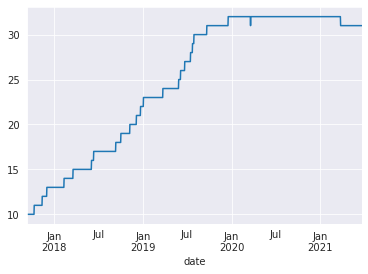

In [77]:
counts_df = data.groupby('date').count()
counts_df['predicted'].plot()

In [78]:
data.groupby('ticker').count()

,predicted,open,close,low,high,volume
ticker,,,,,,
btc-usd,1380,1380,1380,1380,1380,1380
dash-usd,1380,1380,1380,1380,1380,1380
eos-usd,1380,1380,1380,1380,1380,1380
etc-usd,1380,1380,1380,1380,1380,1380
eth-usd,1380,1380,1380,1380,1380,1380
ltc-usd,1380,1380,1380,1380,1380,1380
miota-usd,1380,1380,1380,1380,1380,1380
xmr-usd,1380,1380,1380,1380,1380,1380
xrp-usd,1380,1380,1380,1380,1380,1380


In [79]:
data=data.swaplevel()
data

,,predicted,open,close,low,high,volume
ticker,date,,,,,,
btc-usd,2017-09-10 00:00:00+00:00,0.010700,4315.399902,4236.000000,3974.100098,4330.000000,4.587653e+04
dash-usd,2017-09-10 00:00:00+00:00,0.022660,324.250000,324.500000,295.450012,328.660004,1.093469e+04
eos-usd,2017-09-10 00:00:00+00:00,0.030799,0.810000,0.739990,0.691800,0.815380,4.303528e+06
etc-usd,2017-09-10 00:00:00+00:00,0.015021,16.280001,15.208000,14.250000,16.280001,4.241054e+05
eth-usd,2017-09-10 00:00:00+00:00,0.005033,303.200012,299.000000,276.109985,305.000000,2.553364e+05
...,...,...,...,...,...,...,...
xlm-usd,2021-06-20 00:00:00+00:00,-0.012995,0.288840,0.297500,0.270160,0.299250,2.255776e+06
xmr-usd,2021-06-20 00:00:00+00:00,-0.022114,267.970001,264.760010,248.740005,271.230011,3.941147e+03
xrp-usd,2021-06-20 00:00:00+00:00,-0.016854,0.759940,0.776640,0.698280,0.785670,1.654770e+07


In [80]:

print("loading...")
def bt_adddata(bt_cerebro, data):
    idx = pd.IndexSlice
    tickers = data.index.get_level_values('ticker').unique()
    benchmark_btc = None

    for ticker in tqdm(tickers):
        df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
        df.index.name = 'datetime'
        bt_data = SignalData(dataname=df)
        bt_cerebro.adddata(bt_data, name=ticker)
        if ticker == 'btc-usd':
            benchmark_btc = df
    return benchmark_btc
benchmark_btc = bt_adddata(bt_cerebro=cerebro, data=data)
benchmark_btc

  0%|          | 0/32 [00:00<?, ?it/s]

loading...


100%|██████████| 32/32 [00:00<00:00, 670.43it/s]


,predicted,open,close,low,high,volume
datetime,,,,,,
2017-09-10 00:00:00+00:00,0.010700,4315.399902,4236.000000,3974.100098,4330.000000,45876.532765
2017-09-11 00:00:00+00:00,0.014307,4233.500000,4194.700195,4123.000000,4383.200195,30897.420909
2017-09-12 00:00:00+00:00,-0.001733,4200.500000,4149.500000,4050.000000,4379.000000,40047.827079
2017-09-13 00:00:00+00:00,0.004154,4149.399902,3861.399902,3731.699951,4160.000000,71503.227621
2017-09-14 00:00:00+00:00,0.030390,3849.699951,3223.300049,3204.699951,3917.199951,127510.723806
...,...,...,...,...,...,...
2021-06-16 00:00:00+00:00,0.020286,40143.000000,38276.082031,38121.000000,40460.000000,6793.177374
2021-06-17 00:00:00+00:00,-0.014836,38345.000000,38081.000000,37387.000000,39519.000000,3538.419505
2021-06-18 00:00:00+00:00,0.016774,38074.000000,35668.000000,35137.000000,38184.097656,11421.098814


In [81]:
#data = None
#prices = None

### Strategy

Includes an option to only trade on certain weekdays in lines 39/40.

In [82]:
class MLStrategy(bt.Strategy):
    params = (('n_positions', 10),
              ('min_positions', 5),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    #def prenext(self):
    #    self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)

        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')
        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')


In [83]:
class MLStrategy_relative(bt.Strategy):
    params = (('n_positions', 0.2),
              ('min_positions', 0.1),
              ('verbose', False),
              ('log_file', 'MLStrategy_relative.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # get number of available tickers
        n_available_tickers = len(self.datas)
        self.log(f'{n_available_tickers} available on {today}')

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)

        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')
        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')



### Run Strategy Backtest

In [84]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
#cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
#cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')

In [85]:
n_positions = [32, 24, 16, 12, 8, 5]
min_positions = [8, 4, 2, 1]

In [86]:
print("start")

cerebro.optstrategy(MLStrategy_relative, verbose=True,
                    min_positions=min_positions,
                    n_positions=n_positions)

start = time()

results = cerebro.run(stdstats=False, optreturn=False)
ending_value = cerebro.broker.getvalue()
print(f'Duration: {format_time(time() - start)}')

start
Duration: 00:01:14


### Plot result

Disabled because large number of datafeeds all plot separately.

In [87]:
#figure = cerebro.plot(iplot=True, volume=False)[0][0]
#cerebro.plot()  # plot the results
#figure = cerebro.plot(iplot=False)[0][0]
#figure.savefig(f'backtrader2.svg')
#figure.show()


### Sort for best strategy


### Analyzer results

In [88]:
xzy = []
for result in results:
    xzy.append([result[0].broker.getvalue(),
                result[0].p.min_positions,
                result[0].p.n_positions,
                result[0]])
xzy.sort(reverse=True)

best_strategy = xzy[0][3]
xzy

[[10391775.29265118, 1, 24, <__main__.MLStrategy_relative at 0x7f092169ed30>],
 [5842238.923179261, 1, 32, <__main__.MLStrategy_relative at 0x7f091369adc0>],
 [575668.9680647484, 1, 16, <__main__.MLStrategy_relative at 0x7f090487bbe0>],
 [524082.5114383968, 2, 24, <__main__.MLStrategy_relative at 0x7f09a76be7c0>],
 [453696.083259523, 2, 32, <__main__.MLStrategy_relative at 0x7f09d57dc400>],
 [15908.370131487525, 2, 16, <__main__.MLStrategy_relative at 0x7f09710e3040>],
 [12079.540193226016, 1, 12, <__main__.MLStrategy_relative at 0x7f08aa00fee0>],
 [10000.0, 8, 5, <__main__.MLStrategy_relative at 0x7f0d985ec910>],
 [5047.959973085255, 4, 32, <__main__.MLStrategy_relative at 0x7f0993009b20>],
 [2608.520727365776, 4, 24, <__main__.MLStrategy_relative at 0x7f09d587ff40>],
 [334.31374166210765, 8, 32, <__main__.MLStrategy_relative at 0x7f0d985a4250>],
 [277.1822449890441, 2, 12, <__main__.MLStrategy_relative at 0x7f097117bf70>],
 [103.74770517954423, 8, 24, <__main__.MLStrategy_relative at

In [89]:
pyfolio_analyzer = best_strategy.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [90]:
# results[0][0].analyzers.getbyname('tradeanalyzer').print()

In [91]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2017-09-14 00:00:00+00:00,1.079056e-01,3849.699951,0,btc-usd,-415.404176
2017-09-14 00:00:00+00:00,-1.393534e+00,298.329987,1,dash-usd,415.732980
2017-09-14 00:00:00+00:00,5.747126e+02,0.725000,2,eos-usd,-416.666667
2017-09-14 00:00:00+00:00,2.940485e+01,14.126000,3,etc-usd,-415.372863
2017-09-14 00:00:00+00:00,1.510428e+00,275.480011,4,eth-usd,-416.092743
...,...,...,...,...,...
2021-06-20 00:00:00+00:00,2.242959e+03,2.592300,26,leo-usd,-5814.422161
2021-06-20 00:00:00+00:00,2.968087e+03,0.936770,28,algo-usd,-2780.415043
2021-06-20 00:00:00+00:00,-1.036034e+06,0.859850,29,amp-usd,890833.914556


### Get `pyfolio` inputs

In [92]:
"""
benchmark = web.DataReader('SP500', 'fred', '2017', '2022').squeeze()
benchmark = benchmark.resample('D')
benchmark = benchmark.ffill()
benchmark = benchmark.dropna()
benchmark = benchmark.pct_change().tz_localize('UTC')
benchmark
"""

"\nbenchmark = web.DataReader('SP500', 'fred', '2017', '2022').squeeze()\nbenchmark = benchmark.resample('D')\nbenchmark = benchmark.ffill()\nbenchmark = benchmark.dropna()\nbenchmark = benchmark.pct_change().tz_localize('UTC')\nbenchmark\n"

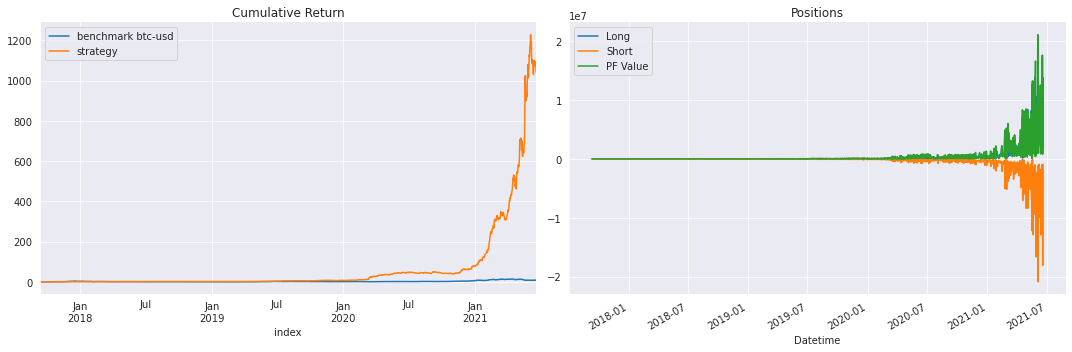

In [93]:
benchmark_btc2 = benchmark_btc['close'].pct_change().rename('btc/usd-benchmark')


fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

benchmark_btc2.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return', label="benchmark btc-usd")
returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return', label='strategy')
axes[0].legend()
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())
longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout()


In [94]:
# prepare pyfolio inputs
#pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
#returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')


## Run pyfolio analysis

In [95]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')


Start date,2017-09-10
End date,2021-06-20
Total months,65
,Backtest
Annual return,255.528%
Cumulative returns,103817.753%
Annual volatility,47.7%
Sharpe ratio,2.89
Calmar ratio,10.54
Stability,0.90
Max drawdown,-24.245%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.24,2018-10-12,2018-12-21,2019-01-13,66
1,21.36,2020-09-10,2020-11-04,2020-11-21,52
2,16.37,2020-06-29,2020-08-31,2020-09-06,50
3,16.09,2021-06-04,2021-06-12,NaT,NaN
4,15.47,2019-11-24,2019-12-15,2019-12-19,19


Stress Events,mean,min,max
New Normal,0.55%,-10.23%,37.45%


Top 10 long positions of all time,max
sid,
wbtc-usd,7786.47%
zec-usd,7269.25%
enj-usd,7223.20%
miota-usd,7158.36%
bat-usd,7053.41%
atom-usd,3567.67%
ftt-usd,3512.00%
bsv-usd,3511.81%
dgb-usd,417.99%


Top 10 short positions of all time,max
sid,
ltc-usd,-3591.79%
btc-usd,-3588.64%
okb-usd,-3581.51%
algo-usd,-3574.70%
amp-usd,-3567.67%
btt-usd,-3567.67%
chz-usd,-3567.67%
leo-usd,-374.74%
xtz-usd,-345.48%


Top 10 positions of all time,max
sid,
wbtc-usd,7786.47%
zec-usd,7269.25%
enj-usd,7223.20%
miota-usd,7158.36%
bat-usd,7053.41%
ltc-usd,3591.79%
btc-usd,3588.64%
okb-usd,3581.51%
algo-usd,3574.70%


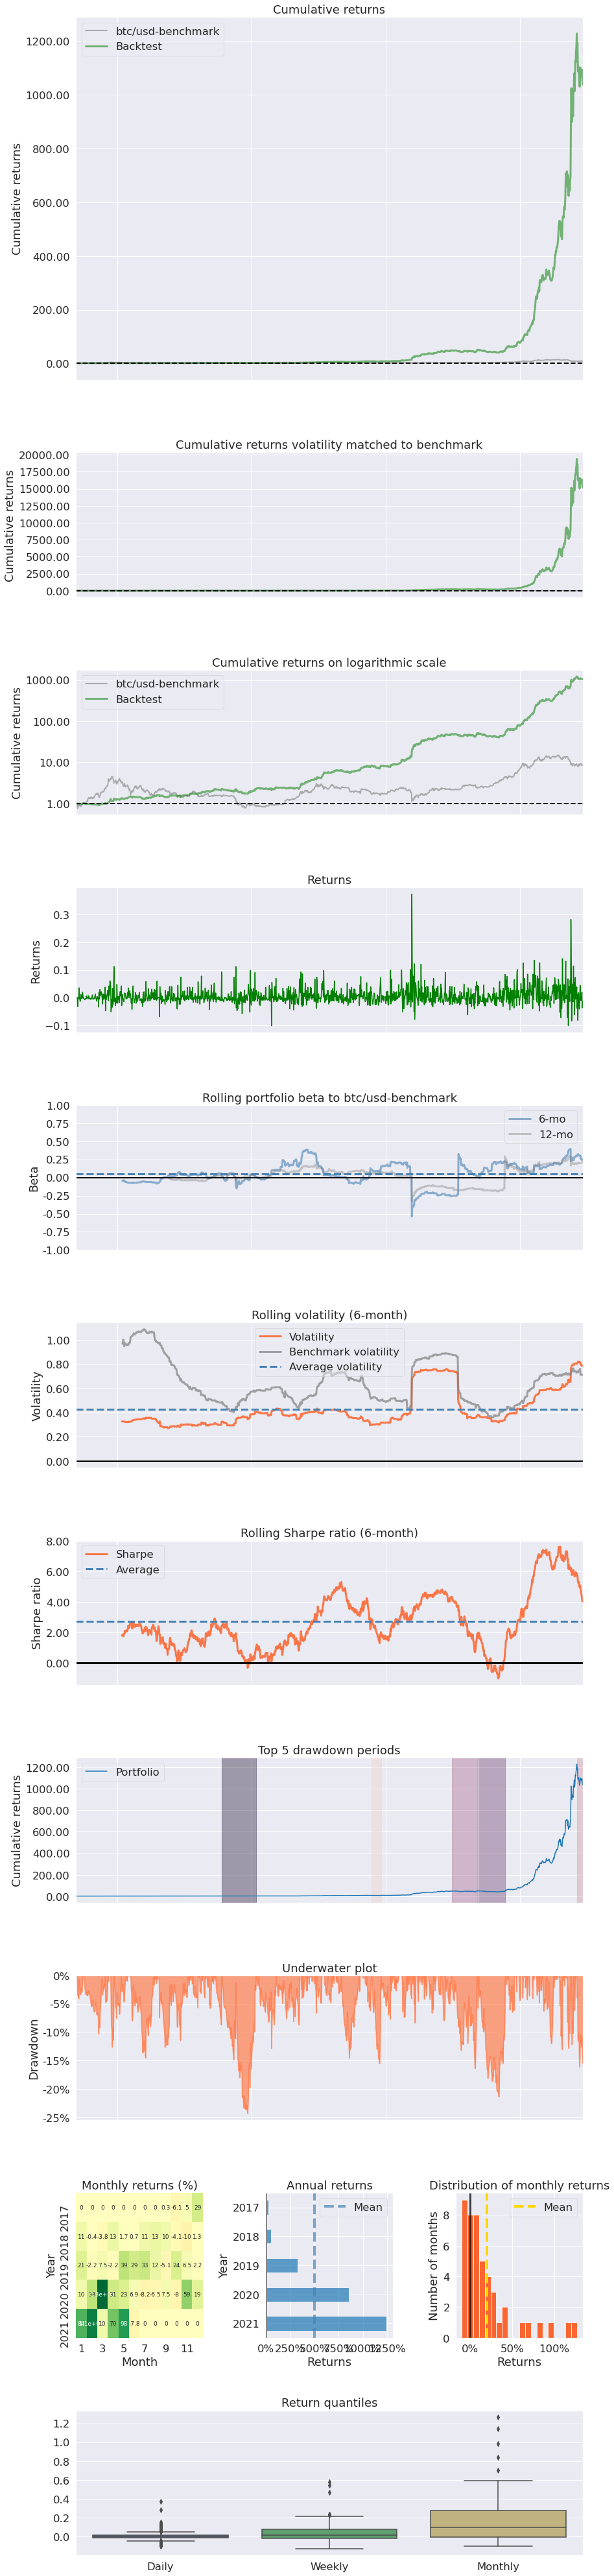

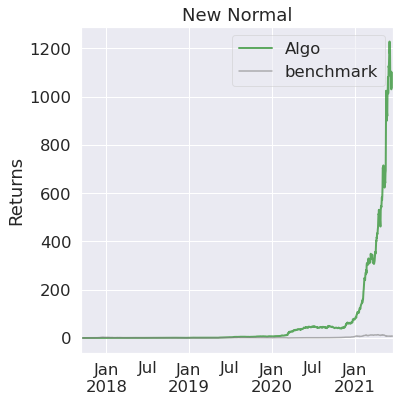

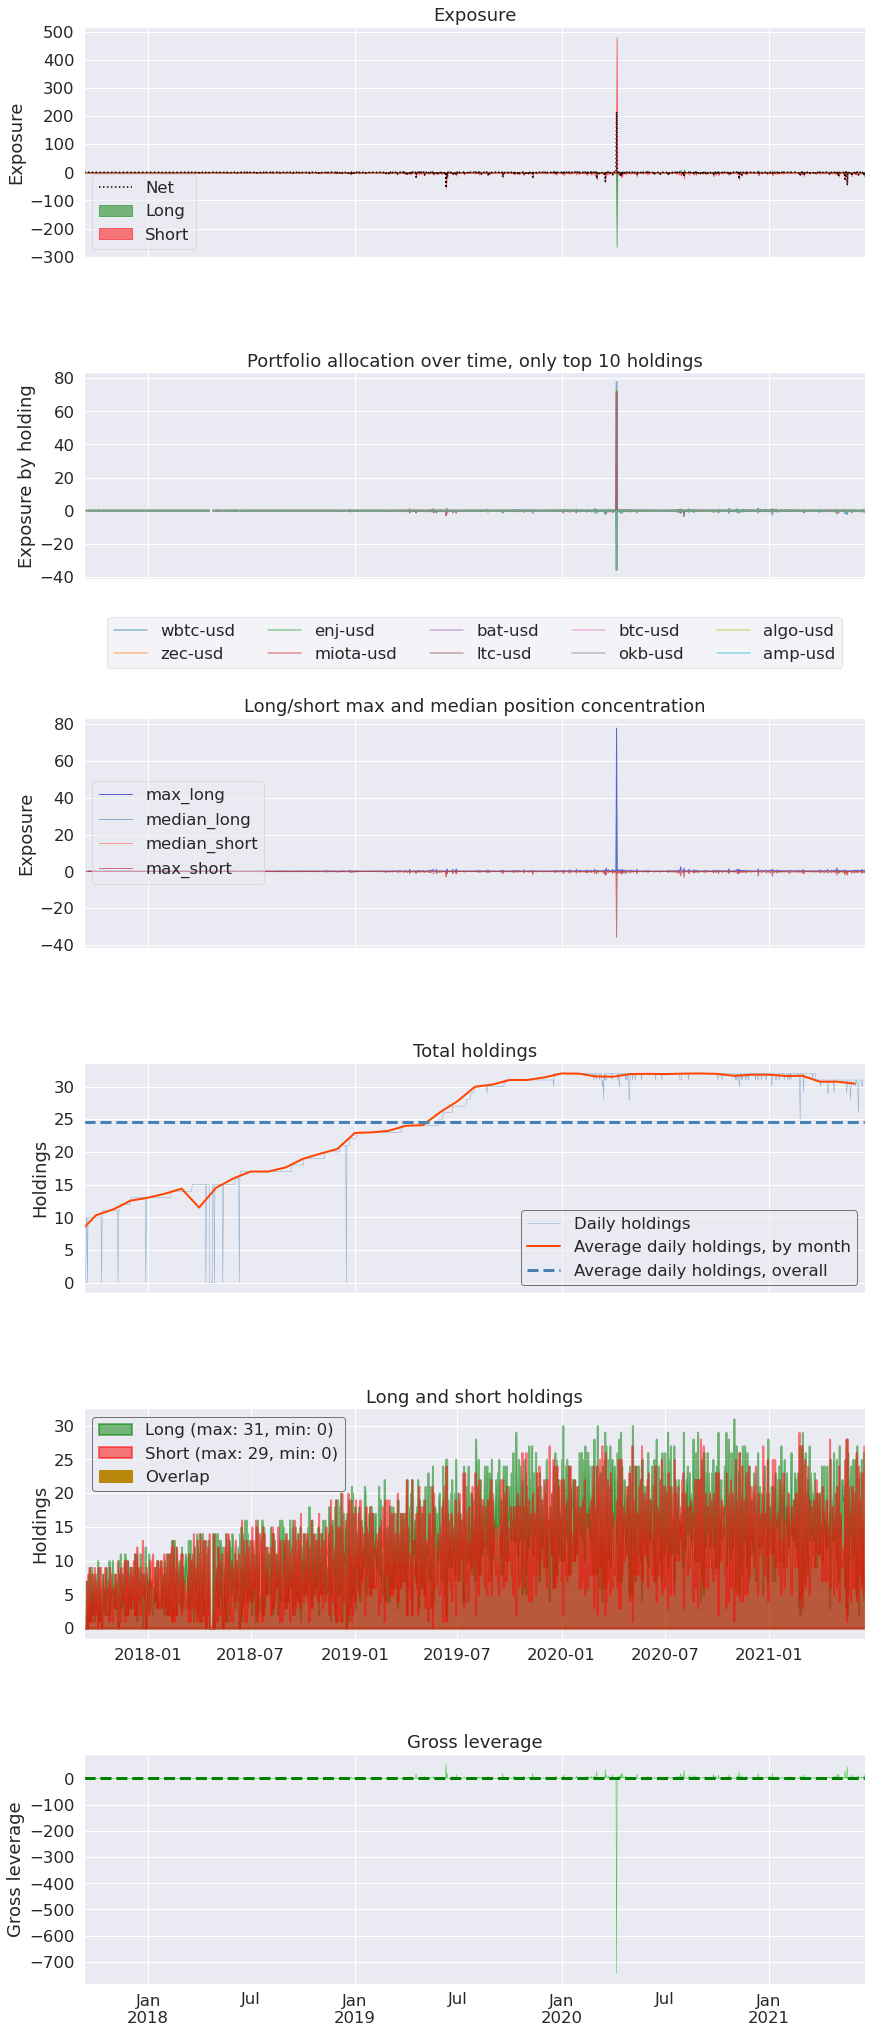

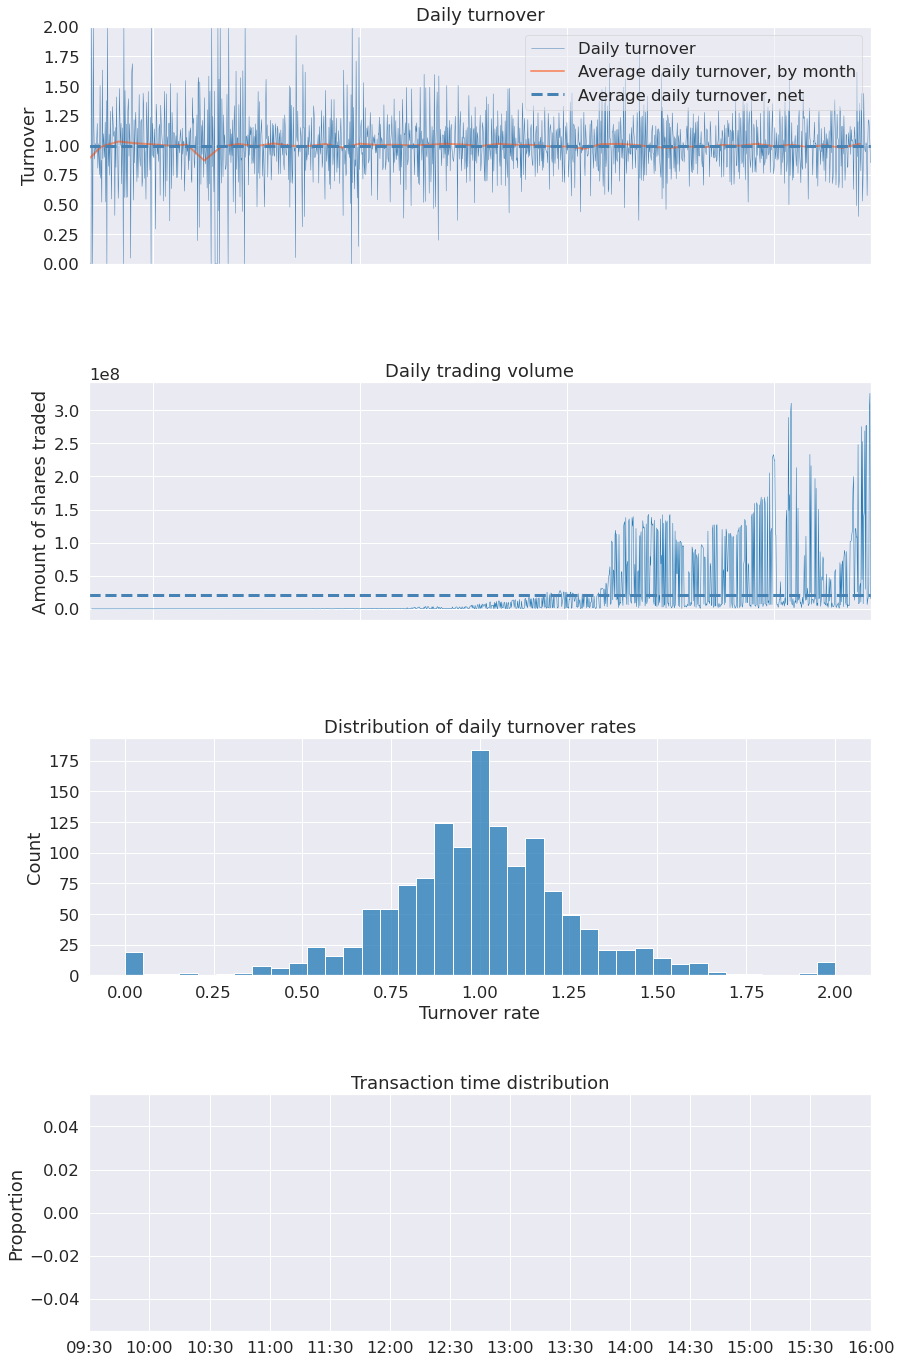

In [96]:
pyfolio = pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark_btc2)